# Fashion Image Captioner

This notebook finetunes a general visual language model (VLM) that can caption images to be able to generate more specific search-relevant descriptions of images from thrifted fashioin item inventories

# Prepare Environment

In [63]:
#Import Libraries

#General
import os
import gc

#Standard ML
from pandas import read_csv
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

#Data Visualization
from torchvision.transforms import ToPILImage
from PIL import Image as pilImage
from IPython.display import display

#HuggingFace Libraries
from datasets import Dataset as hfDataset
from datasets import Image
from accelerate import Accelerator

#The Model
from transformers import Blip2ForConditionalGeneration #visual language model (VLM) can do multimodal tasks like captioning or answering questions about images.
from transformers import Blip2Processor

#Extras
from tqdm import tqdm #cute loading percent bar


In [64]:
# Check GPU Availability
# Device will be reset automatically later by accelerator, but this is a good sanity check to know what we should be working with

# Check for MPS availability
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple's MPS
    print(f"Using torch version {torch.__version__}")
    print("Found MPS is available for use") # Is MPS even available? macOS 12.3+
    print(f"Current version on Pytorch was built with MPS activation: {torch.backends.mps.is_built()}") # Was the current version of PyTorch built with MPS activated?
elif torch.cuda.is_available():
    device = torch.device("cuda")
    nGPUs = torch.cuda.device_count()
    print(f"Found {nGPUs} cuda GPUs available for use")
else:
    device = torch.device("cpu")
    print("No GPU device found, running on cpu")

Found 1 cuda GPUs available for use


# Import Data

To use as-is, a root project folder should contain
* a subproject folder containing this notebook (can have any name)
* a data folder, called Data, containing
  *  DB_FILENAME: a csv file with at least two columns
     *   IMAGE_PATH_COL: contains image names
     *   CAPTION_COL: contains image cpations
  * IMAGE_FOLDERNAME: A folder containing images with the names referenced in IMAGE_PATH_COL
 
The logic for this sturcture is that there can be multiple subprojects that need to access the same dataset

In [65]:
#SET IMAGE LOCATION INFO

#Specify Data Locations
CSV_FILENAME_g = 'item_descriptions.csv' #'large_fashion_descriptions' #'ThredupData.csv'
CAPTION_COL_g = "description"
IMAGE_PATH_COL_g = "filename"
IMAGE_FOLDERNAME_g = 'StanfordJpegs\dedupped_images' #'Extracted_Images'  #'StanfordJpegs'

DATA_FOLDER_g = os.path.join('data') #'..' means the folder one up from current notebook's folder, which happens to be where I have my data folder
IMAGE_FOLDER_g = os.path.join(DATA_FOLDER_g, IMAGE_FOLDERNAME_g)
CSV_FILEPATH_g = os.path.join(DATA_FOLDER_g, CSV_FILENAME_g)

In [66]:
IMAGE_FOLDER_g

'data\\StanfordJpegs\\dedupped_images'

In [67]:
#IMPORT RAW DATA TO DATAFRAME

def getDatasetDF(csv_filepath = CSV_FILEPATH_g, image_folder = IMAGE_FOLDER_g):
    
    """
    Create dataframe based on csv file
    returns data_df which has infomration to eventually create two columns: captions (string descriptions of images) and images (paths to image files) and c
    """
    
    if len(csv_filepath) == 0:
        return
    data_df = read_csv(csv_filepath)
    data_df.index.name = "df_id" #name index to be used for matching datapoints across imported df, hugging face train/test sets and torch dataloaders
    
    return data_df # Should have 
    

data_df_g = getDatasetDF()
data_df_g.head(20)

,filename,description
df_id,,
0,item108153495.jpg,This is a burgundy women's blouse featuring a ...
1,item112414117.jpg,The item is a classic black suede pump featuri...
2,item112851743.jpg,These are women's coral pink straight-leg capr...
3,item111933518.jpg,This is a black suede peep-toe ankle boot feat...
4,item110548869.jpg,"The item is a pair of straight-leg, red pants ..."
5,item106874647.jpg,"This is a classic, long-sleeved white button-u..."
6,item111414733.jpg,This is a classic black leather knee-high boot...
7,item110695025.jpg,"This is an off-white, cozy, cable knit sweater..."
8,item112262250.jpg,This fashion item is a black ankle boot constr...


In [68]:
#Optionally manually edit dataframe to explore effect of individual changes

changeDataManually_g = False

def changeRows(data_df = data_df_g, colToChange = CAPTION_COL_g, should_change=changeDataManually_g):
    if not should_change: return data_df
    else:
        colToChange = "Captions"
        changeDict = {
            846: "a black ankleboot with fringe detailing on the side",
            4815: "a yellow beanie on a white background",
            5093: "a cage-style heel with floral print",
            2835: "a black leather heeled boot with a pointed toe"   
            }
        
        for itemId, content in changeDict.items():
            data_df.loc[itemId,colToChange] = content
        return data_df


data_df_g = changeRows()

In [69]:
#FILTER DATAFRAME TO JUST 3 COLUMNS: df_id, image_paths, captions

def imagePathColCreator(data_df, image_folder, image_path_col):
    #image_paths = list(os.path.join(image_folder,('item'+str(fileId))) for fileId in data_df["Item_Id"]) #From original ThredupData.csv Use ItemId column to create list of paths to image files
    print(data_df.columns)
    image_paths = list(os.path.join(image_folder,filePath) for filePath in data_df[image_path_col]); #From Esra's LLM generated caption dataset (files in folder and spreadhseet adjusted to include .jpg in name)
    return image_paths

def captionColCreator(data_df, caption_col):
    #captions = list(data_df["Category_Type"] + ", " + data_df["Description"]) #If using original ThredupData.csv, use Description column to create list of captions for each image  
    captions = data_df[caption_col] #From Esra's LLM generated caption dataset
    return captions

def createImageAndCaptionDf(data_df = data_df_g, image_folder = IMAGE_FOLDER_g, image_path_col= IMAGE_PATH_COL_g, caption_col = CAPTION_COL_g ):

    #Create image paths
    data_df["image_paths"] = imagePathColCreator(data_df, image_folder, image_path_col)

    #Create caption paths
    data_df["captions"] = captionColCreator(data_df, caption_col)
     
    #Discard rows without valid image paths
    print(f"Original samples in dataframe: {len(data_df)}")
    valid_rows = [ind for ind, image_path in enumerate(data_df["image_paths"]) if os.path.exists(image_path)] #Get rid of any image paths that do not point to actual image files
    invalid_rows = [ind for ind in data_df.index if ind not in valid_rows]

    invalid_data_df = data_df.iloc[invalid_rows]
    print(f"Samples with invalid image paths in dataframe: {len(invalid_data_df)}")
    data_df = data_df.iloc[valid_rows]
    print(f"Samples with valid image paths in dataframe: {len(data_df)}")

    #Discard all other columns
    data_df = data_df[["captions", "image_paths"]]

    return data_df, invalid_data_df

data_df_g, invalid_paths_df_g = createImageAndCaptionDf()

data_df_g.head()
    

Index(['filename', 'description'], dtype='object')
Original samples in dataframe: 151
Samples with invalid image paths in dataframe: 123
Samples with valid image paths in dataframe: 28


,captions,image_paths
df_id,,
4,"The item is a pair of straight-leg, red pants ...",data\StanfordJpegs\dedupped_images\item1105488...
6,This is a classic black leather knee-high boot...,data\StanfordJpegs\dedupped_images\item1114147...
7,"This is an off-white, cozy, cable knit sweater...",data\StanfordJpegs\dedupped_images\item1106950...
10,"These are red, straight-cut, mid-rise trousers...",data\StanfordJpegs\dedupped_images\item1050674...
12,"This is a long-sleeved, deep plum blouse featu...",data\StanfordJpegs\dedupped_images\item1030034...


# Separate Train/Valid/Test Dataframes

In [70]:
#Training Toggles

VALIDATION_PORTION_g = 0.2
TEST_PORTION_g = .1
SEED_g = 22

In [71]:
# Initialize variables for train/validation/test dataframes, huggingface datasets, and torch data loaders
train_df_g = None
train_hfset_g = None
train_dataloader_g = None

validation_df_g = None
validation_hfset_g = None
validation_dataloader_g = None

test_df_g = None
test_hfset_g = None
test_dataloader_g = None


In [72]:
#Populate train/validation/test dataframes

# Split off training data
train_df_g, test_and_validation_df_g = train_test_split(data_df_g, test_size=(VALIDATION_PORTION_g + TEST_PORTION_g), random_state=SEED_g)

#Split remaining into validation and test dats
validation_df_g, test_df_g = train_test_split(test_and_validation_df_g, test_size=TEST_PORTION_g, random_state=SEED_g)

print(f"""
Train Size: {len(train_df_g)},
Validation Size: {len(validation_df_g)},
Test Size: {len(test_df_g)} 
""")
train_df_g.head()


Train Size: 19,
Validation Size: 8,
Test Size: 1 



,captions,image_paths
df_id,,
67,"This item is a pair of vibrant red, straight-l...",data\StanfordJpegs\dedupped_images\item1000016...
43,This is a classic black suede pump with a poin...,data\StanfordJpegs\dedupped_images\item1097147...
7,"This is an off-white, cozy, cable knit sweater...",data\StanfordJpegs\dedupped_images\item1106950...
33,This is a classic-fit white dress shirt made f...,data\StanfordJpegs\dedupped_images\item1064935...
68,This is a contemporary-style black pebbled lea...,data\StanfordJpegs\dedupped_images\item1093901...


# Create Hugging Face Datasets


In [73]:
#Create train, valid, test huggingface datasets

def createHuggingfaceDataset(data_df):
    image_paths = list(data_df["image_paths"])
    captions = list(data_df["captions"])
    dataframe_ids = data_df.index.tolist()
    
    #Create HuggingFace Dataset from python dict containing two lists, image paths and captions
    dataset_hf = hfDataset.from_dict(
                                {
                                    "image": image_paths,
                                    "text": captions,
                                    "df_id": dataframe_ids
                                }
                            )
    dataset_hf = dataset_hf.cast_column("image", Image()) #Cast the image column to image data type so can be linked files can be accessed as images

    #Delete variables to free up memory (may not be necessary)
    del [image_paths, captions, data_df, dataframe_ids]
    gc.collect() #collect garbage 
    
    return dataset_hf

train_hfset_g = createHuggingfaceDataset(train_df_g)
print("training hugging face dataset created")

validation_hfset_g = createHuggingfaceDataset(validation_df_g)
print("validation hugging face dataset created")

test_hfset_g = createHuggingfaceDataset(test_df_g)
print("test hugging face dataset created")

training hugging face dataset created
validation hugging face dataset created
test hugging face dataset created


# Make Functions to Go Btwn df and hf

In [74]:
#Create function for selecting train/test/valid dataset

def select_df_hf(segment,
                   train_df = train_df_g,
                   train_hfset = train_hfset_g,
                   validation_df = validation_df_g,
                   validation_hfset = validation_hfset_g,
                   test_df = test_df_g,
                   test_hfset = test_hfset_g):

    if segment == "train":
        return  train_df, train_hfset
    elif segment == "validation":
        return  validation_df, validation_hfset
    elif segment == "test":
        return  test_df, test_hfset

#train_df, train_hfset = select_df_hf("train")

In [75]:
# Create table with df_id, hf_segment_id for conversion

def create_uid_df(train_hfset, validation_hfset, test_hfset):

    uid_df = DataFrame(columns = ["df_id", "segment", "hf_segment_id"])
    
    hf_segments = {
        "train": train_hfset,
        "validation": validation_hfset,
        "test": test_hfset
    }
    
    for hf_segment_name, hf_segment in hf_segments.items():
        for row_id, hf_item in enumerate(hf_segment):
            item_id = hf_item["df_id"]
            uid_df.loc[item_id, "df_id"] = item_id
            uid_df.loc[item_id, "segment"] = hf_segment_name
            uid_df.loc[item_id,"hf_segment_id"] = row_id

    return uid_df

uid_df_g = create_uid_df(train_hfset_g, validation_hfset_g, test_hfset_g)
uid_df_g.head()
    

,df_id,segment,hf_segment_id
67,67,train,0
43,43,train,1
7,7,train,2
33,33,train,3
68,68,train,4


In [76]:
# Function to convert from hf_id to uid

def get_uid_from_hf_segment_id(segment, hf_segment_id, uid_df = uid_df_g):
    df_id = uid_df.loc[(uid_df["segment"] == segment) & (uid_df["hf_segment_id"] == hf_segment_id), "df_id"]
    assert len(df_id) == 1
    uid = df_id.values[0]
    return uid

#Example 
segment_g = "train"
hf_id_g = 0
print(f"The uid of hf {segment_g}, ex {hf_id_g}:")
print(get_uid_from_hf_segment_id(segment_g, hf_id_g))

The uid of hf train, ex 0:
67


# View Labeled Data Examples

HUGGING FACE IMAGE:


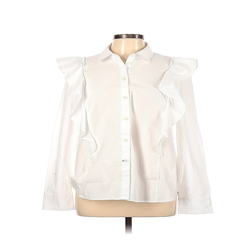

HUGGING FACE CAPTION:
This is a classic women's white cotton blouse featuring a structured shape with dramatic ruffle detailing on the shoulders, a standard collar, button-up front, and long sleeves, potentially suiting a business-casual style or a vintage-inspired look.

ORIGINAL DF INFO:
captions       This is a classic women's white cotton blouse ...
image_paths    data\StanfordJpegs\dedupped_images\item1002463...
Name: 75, dtype: object


In [77]:
#Select image to view huggingface and original dataframe data

segment_to_view_g = "train"
segment_ind_g = 6 #index of image to look at in train/validation/test segment

def view_labeled_data_example(segment = segment_to_view_g, hf_id = segment_ind_g):

        dfset, hfset = select_df_hf(segment)
        df_id = get_uid_from_hf_segment_id(segment, hf_id)
 
        #hf image
        image = hfset[hf_id]["image"].resize((252,252))
        print("HUGGING FACE IMAGE:")
        display(image)
        
        #hf caption
        print(f'HUGGING FACE CAPTION:\n{hfset[hf_id]["text"]}\n')
        
        #original dataframe info
        print(f'ORIGINAL DF INFO:\n{dfset.loc[df_id]}')

view_labeled_data_example()

# Import Datasets to Dataloaders

In [78]:
#Create Pytorch Dataset Class for input o Dataloaders

class ImageCaptioningDataset(Dataset): #this class inherits functionalities and structure of the pytorch Dataset class
    
    def __init__(self, huggingFaceDataset, processor):       
        self.dataset = huggingFaceDataset
        self.processor = processor
        #self.new_size = (256,256)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        item = self.dataset[idx] #each item in self.dataset has an image and text
        
        #process image (returns a dictionary with a single item containing the processed image)
        encoding = self.processor(images = item["image"], #get image
                                  #.resize(self.new_size), #resize
                                  #padding = "max_length", #set padding
                                  return_tensors = "pt" #return as pytorch tensor dtype
                                 )
        
        # remove batch dimension
        encoding = {key: value.squeeze() for key, value in encoding.items()} #

        #add text info
        encoding["text"] = item["text"]

        # Include the original index (from hugging face) in the returned data
        encoding['hf_idx'] = idx
        
        return encoding

    def get_original_image(self, idx):
        #This method gets the original image from the Hugging Face dataset for a given index.
        return self.dataset[idx]["image"]



In [79]:
#Create Processor which does image and caption pre-processing
# (used in creation of pytorch dataset and collate functions)

def getProcessor():
    pretraining = 'Salesforce/blip2-opt-2.7b'
    processor = Blip2Processor.from_pretrained(pretraining)
    return processor

processor_g = getProcessor()

In [80]:
def collate_fn(batch, processor = processor_g):

    #batch is a list of examples (dictionaries), where each example has the same keys (image and text)
    
    # pad the tokenized_captions and attention_mask
    processed_batch = {}
    
    item_keys = batch[0].keys()
    
    for key in item_keys: #only have to iterate over keys from first example in batch, bc all examples have same keys
        if key == "pixel_values":
            processed_batch[key] = torch.stack([item[key] for item in batch]) #stack images from all examples in batch
        elif key == "text":
            #tokenize the caption (ie break up caption into chunks and convert each chunk to a number using look up table)
            text_inputs = processor.tokenizer(
                                            [item["text"] for item in batch], 
                                            padding = "max_length" ,#True, 
                                            max_length = 50, #9, #16
                                            return_tensors = "pt",
                                            truncation = True,
                                            )
            processed_batch["tokenized_captions"] = text_inputs["input_ids"] #input_ids is conventionally used in the Hugging Face Transformers library and other NLP frameworks to refer to the tokenized representation of text inputs. This naming convention is primarily for consistency and clarity within the context of language models and their input processing
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
        elif key == "hf_idx":
            processed_batch[key] = [item[key] for item in batch]
        else:
            print(f"{key} KEY NOT ACOUNTED FOR !!")
    
    return processed_batch

In [81]:
#CREATE PYTORCH DATA LOADERS

BATCH_SIZE_g = 16 #(32+ Too Big on my Vast.AI instance) #56 #64 #128 #512 #1024
processor_g = getProcessor()

train_dataloader_g = DataLoader(dataset = ImageCaptioningDataset(train_hfset_g, processor_g), 
                              shuffle = True, 
                              batch_size = BATCH_SIZE_g, 
                              collate_fn = collate_fn,
                             )

validation_dataloader_g = DataLoader(dataset = ImageCaptioningDataset(validation_hfset_g, processor_g), 
                               batch_size = BATCH_SIZE_g, 
                               collate_fn = collate_fn,
                              )

test_dataloader_g = DataLoader(dataset = ImageCaptioningDataset(validation_hfset_g, processor_g), 
                               batch_size = BATCH_SIZE_g, 
                               collate_fn = collate_fn,
                              )

# del train_hfset

In [82]:
def select_dataset(segment,
                   train_dataloader = train_dataloader_g,
                   validation_dataloader = validation_dataloader_g,
                   test_dataloader = test_dataloader_g):

    selected_df, selected_hfset = select_df_hf(segment)
    if segment == "train":
        return  selected_df, selected_hfset, train_dataloader
    elif segment == "validation":
        return  selected_df, selected_hfset, validation_dataloader
    elif segment == "test":
        return  selected_df, selected_hfset, test_dataloader

#train_df, train_hfset, train_dataloader = select_dataset("train")

# Get Model

In [83]:
# LOAD MODEL
model_g = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", 
                                                      torch_dtype = torch.float32
                                                     )

Loading checkpoint shards: 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


In [84]:
# LOAD LoRA CONFIG

#maybe it would be better to save weights from LoRA

from peft import LoraConfig, get_peft_model   
    
config_g = LoraConfig(
    r = 10, #32, #10, #18, #16, # Rank size determined number of trainable parameters.
    lora_alpha = 32, # scaling factor sets magnitude LoRA updates have on the original weights
    lora_dropout = 0.05, #percent of cells not enabled at any time
    bias = "none",
    target_modules = ["q_proj", "k_proj"] #focus model's adaptation on the attention mechanism
)

model_g = get_peft_model(model_g, config_g) #peft model is the hugging face name for their library that uses LORA "parameter efficient fine-tuning"
    
model_g.print_trainable_parameters()

trainable params: 3,276,800 || all params: 3,747,956,736 || trainable%: 0.08742897079162015


In [85]:
# # OPTIMIZER
lr_g = 1e-4 #2e-4 #5e-4 #8e-4
optimizer_g = torch.optim.Adam(model_g.parameters(), lr = lr_g)

In [86]:
# # ACCELERATOR
# # optimizes training and evaluation loops for the available hardware in a device agnostic way,
# # eliminating need to use .to(device) or wrap model with torch.nn.DataParallel for multi-GPU training

accelerator_g = Accelerator() #hugging face optimization handles device placement and optimizes training speed
model_g, optimizer_g, train_dataloader_g, validation_dataloader_g  = accelerator_g.prepare(model_g, optimizer_g, train_dataloader_g, validation_dataloader_g)

device_g = accelerator_g.device
print(f'Device: {device_g}')


Device: cuda


In [87]:

model_g.load_state_dict(torch.load('large_fashion_dataset.pt'))

<All keys matched successfully>

# Set up to Compare Before and After Examples

In [88]:
#SUBFUNCTIONS TO COMPARE LABELS, UNTUNED AND TUNED CAPTIONS

def getSubBatch(dataloader, nSamples):
    nSamples = min(nSamples, len(dataloader.dataset))
    batch_iterator = iter(dataloader) # Create an iterator from the DataLoader
    batch = next(batch_iterator) # Fetch full batch
    subset_batch = {key: value[:nSamples] for key, value in batch.items()}
    n_samples = len(subset_batch)
    return subset_batch, n_samples 

def unpackBatch(batch):
    tokenized_captions = batch["tokenized_captions"]
    pixel_values = batch["pixel_values"].to(torch.float32).to(device_g)
    hf_indices = batch['hf_idx']
    return hf_indices,tokenized_captions, pixel_values

def getModelPredictions(model, processor, pixel_values):
    model.eval()
    predictions = model.generate(pixel_values, max_new_tokens = 100)#9 #16 #Here the predictions are text captions written in number encoded words (LUT)
    predictions = processor.batch_decode(predictions, skip_special_tokens = True) #now we're in english
    return predictions

def decipherLabels(processor, tokenized_captions):
    labels = processor.batch_decode(tokenized_captions, skip_special_tokens = True)
    return labels

def getImage(hf_dataset, hf_ind):
    return hf_dataset[hf_ind]["image"].resize((252, 252))

def showImage(image):
    display(image.resize((252,252)))

def showCaptionComparison(df_id, hf_ind, image, prediction_untuned, prediction_tuned, label):
    print(f"DF Index:{df_id}, Segment index: {hf_ind}")
    showImage(image)
    print(f"UNTUNED CAPTION: {prediction_untuned}\n")
    print(f"TUNED CAPTION: {prediction_tuned}\n")
    print(f"DESIRED CAPTION: {label}\n")
    print('==========\n\n') 

def showCaptionComparisons(segment, hfset, hf_indices, predictions_untuned, predictions_tuned, labels):
    for demo_ind,label in enumerate(predictions_untuned):
        hf_ind = hf_indices[demo_ind]
        df_id = get_uid_from_hf_segment_id(segment, hf_ind)
        image = getImage(hfset, hf_ind)
        showCaptionComparison(df_id, hf_ind, image, predictions_untuned[demo_ind], predictions_tuned[demo_ind], labels[demo_ind])

In [89]:
def compareCaptionsBefore(segment, maxSamples, model=model_g, processor=processor_g ):
    #Get dataset segment (as df, hfset and dataloader)
    df, hfset, dataloader = select_dataset(segment)

    #Get images and labels from segment dataloader
    subset_batch, n_samples = getSubBatch(dataloader, maxSamples)
    hf_indices, tokenized_captions, pixel_value_inputs = unpackBatch(subset_batch)

    #Get predicted captions by applying model
    predictions_untuned = getModelPredictions(model, processor, pixel_value_inputs)
    predictions_tuned = predictions_untuned

    #Get desired captions from labels
    labels = decipherLabels(processor, tokenized_captions)

    #Show comparison
    showCaptionComparisons(segment, hfset, hf_indices, predictions_untuned, predictions_tuned, labels)
    
    return segment, hf_indices, pixel_value_inputs, predictions_untuned, labels

def compareCaptionsAfter(comparison_segment,
                         comparison_hf_indices,
                         comparison_pixel_value_inputs,
                         comparison_predictions_untuned,
                         comparison_labels,
                         model=model_g,
                         processor=processor_g):

    #Get hfset for displaying images
    _, hfset, _ = select_dataset(comparison_segment)

    #Get new predictions
    predictions_tuned = getModelPredictions(model, processor, comparison_pixel_value_inputs)
    
    #Show comparison
    showCaptionComparisons(comparison_segment, hfset, comparison_hf_indices, comparison_predictions_untuned, predictions_tuned, comparison_labels)

DF Index:102, Segment index: 0


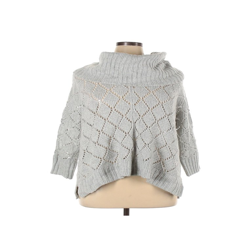

UNTUNED CAPTION: a cozy knit sweater with a flattering scoop neck and a flattering cowl neck make this a perfect layering piece for a cool day at the beach or in the city

TUNED CAPTION: a cozy knit sweater with a flattering scoop neck and a flattering cowl neck make this a perfect layering piece for a cool day at the beach or in the city

DESIRED CAPTION: This is a light grey, cable knit poncho-style sweater with ribbed turtleneck, wide arm openings, and a relaxed, draped fit, likely made from wool or acrylic blend, representing a casual and cozy style possibly from the



DF Index:6, Segment index: 1


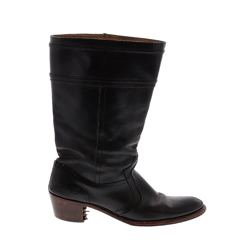

UNTUNED CAPTION: a classic boot with a pointed toe and a high heel are crafted from supple leather with a soft lining and a cushioned footbed for comfort

TUNED CAPTION: a classic boot with a pointed toe and a high heel are crafted from supple leather with a soft lining and a cushioned footbed for comfort

DESIRED CAPTION: This is a classic black leather knee-high boot featuring a slouchy shaft, a stacked heel, rounded toe, and a simple, timeless style that could be versatile for both casual and more dressed-up looks.



DF Index:137, Segment index: 2


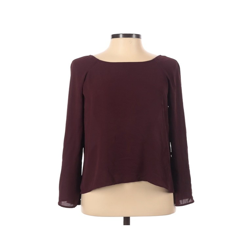

UNTUNED CAPTION: a flattering scoop neck and a flattering fit make this top a must have for your wardrobe

TUNED CAPTION: a flattering scoop neck and a flattering fit make this top a must have for your wardrobe

DESIRED CAPTION: This is a contemporary, burgundy-colored women's blouse with long sleeves, made from a light, possibly synthetic fabric, featuring a relaxed fit, a round neckline, and a high-low hemline that adds a modern touch to



DF Index:10, Segment index: 3


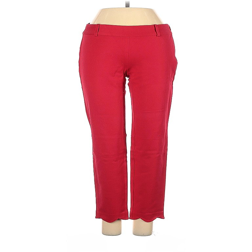

UNTUNED CAPTION: a flattering scalloped hem and a flattering fit make this relaxed pant a go-to for a casual day or weekend look

TUNED CAPTION: a flattering scalloped hem and a flattering fit make this relaxed pant a go-to for a casual day or weekend look

DESIRED CAPTION: These are red, straight-cut, mid-rise trousers likely made from a smooth, non-stretch fabric, featuring a clean waistband without belt loops, and finished with a simple hem, giving off a sleek, modern look suitable for



DF Index:128, Segment index: 4


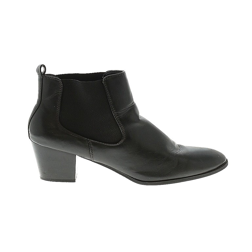

UNTUNED CAPTION: a classic chelsea boot with a pointed toe and a pointed heel are made from a soft leather with a soft hand and a smooth finish

TUNED CAPTION: a classic chelsea boot with a pointed toe and a pointed heel are made from a soft leather with a soft hand and a smooth finish

DESIRED CAPTION: This is a classic black leather Chelsea boot featuring a sleek design with elastic side panels, a modest block heel, a pointed toe, and a pull tab at the back for ease of slipping on, suitable for both casual and semi-formal styles



DF Index:23, Segment index: 5


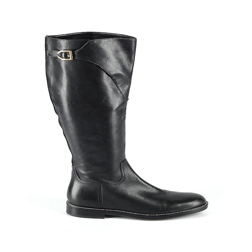

UNTUNED CAPTION: a classic buckle add a touch of class to a boot crafted from supple leather with a high heel and a low toe cut for a comfortable fit

TUNED CAPTION: a classic buckle add a touch of class to a boot crafted from supple leather with a high heel and a low toe cut for a comfortable fit

DESIRED CAPTION: This is a classic black leather knee-high boot featuring a sleek, rounded-toe design with minimal detailing except for a strap with a buckle at the top, suitable for a streamlined look that could complement both casual and slightly more formal attire.



DF Index:147, Segment index: 6


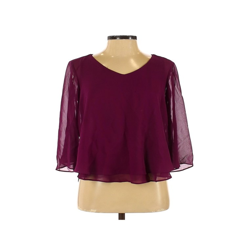

UNTUNED CAPTION: a flattering v neckline and a flattering asymmetrical hemline make this sleeveless blouse a must have for your wardrobe

TUNED CAPTION: a flattering v neckline and a flattering asymmetrical hemline make this sleeveless blouse a must have for your wardrobe

DESIRED CAPTION: This is a women's deep burgundy blouse with sheer long sleeves, featuring a v-neckline and a loose, flowy fit, likely made from a synthetic blend, presenting a simple yet elegant style suitable for various occasions.



DF Index:74, Segment index: 7


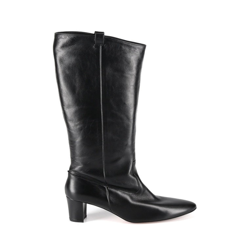

UNTUNED CAPTION: a pointed toe and a pointed heel make this boot a must have for any season

TUNED CAPTION: a pointed toe and a pointed heel make this boot a must have for any season

DESIRED CAPTION: This is a pair of classic black leather knee-high boots featuring a sleek, fitted silhouette with a pointed toe, mid-height block heel, with a full-length zipper on the shaft, likely from a contemporary era and versatile for various styles





In [90]:
#Look at predictions before training
segment_g = "validation"
n_samples_g = 10

comparison_segment_g, comparison_hf_indices_g, comparison_pixel_value_inputs_g, comparison_predictions_untuned_g, comparison_labels_g  = compareCaptionsBefore(segment_g, n_samples_g)

# Train Model

In [91]:
#Define default values

n_epochs_g = 1

In [92]:
def train_model(model, n_epochs = n_epochs_g, train_dataloader = train_dataloader_g, optimizer = optimizer_g, accelerator = accelerator_g): 
    for epoch in range(n_epochs):
        print(f"{epoch= }")
        
        epoch_accumulated_loss = 0
        nBatches = 0        
            
        model.train()
        for batch in tqdm(train_dataloader): #batch is a dictionary

            optimizer.zero_grad()

            #Get X and y
            tokenized_captions = batch.pop("tokenized_captions") #!!!*** pops instead of indexing to save memory (on old hardware)
            pixel_values = batch.pop("pixel_values").to(torch.float32)

            #Get predictions
            outputs = model(input_ids = tokenized_captions, #input_ids is conventional HF name for tokenized text
                            pixel_values = pixel_values,
                            labels = tokenized_captions)
            
            #Calculate loss and train
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()   
            optimizer.zero_grad()

            epoch_accumulated_loss += loss.item()
            nBatches+=1
    
        print(f"Average Loss: {epoch_accumulated_loss/nBatches}")
        
        print("!!!***!!! UNCOMMENT VALIDATION CHECK ONCE IMPLEMENTED")        
        # model.eval()
        
        # rouge_score_aggregator = scoring.BootstrapAggregator()
        # bleu_score_aggregator = scoring.BootstrapAggregator()
    
        # for batch in tqdm(validation_dataloader):
    
        #     tokenized_captions = batch.pop("tokenized_captions")#.to(device)
        #     pixel_values = batch.pop("pixel_values").to(torch.float32)
        
        #     predictions = model.generate(pixel_values, max_length = 10)#9 #16 #Here the predictions are text captions written in number encoded words (LUT)
        #     predictions = processor.batch_decode(predictions, skip_special_tokens = True) #now we're in english
        #     labels = processor.batch_decode(tokenized_captions, skip_special_tokens = True) #these are the pre-set captions (decoded from numbers)
    
        #     eval_metric = compute_metrics(predictions, labels) 
        

In [93]:
# n_epochs_g = n_epochs_g #Set this to a new number if don't want old n_epochs_g
# train_model(model_g, n_epochs_g)

In [94]:
# torch.save(model_g.state_dict(), 'large_fashion_dataset.pt')

In [98]:
model_g

PeftModel(
  (base_model): LoraModel(
    (model): Blip2ForConditionalGeneration(
      (vision_model): Blip2VisionModel(
        (embeddings): Blip2VisionEmbeddings(
          (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (encoder): Blip2Encoder(
          (layers): ModuleList(
            (0-38): 39 x Blip2EncoderLayer(
              (self_attn): Blip2Attention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear(in_features=1408, out_features=4224, bias=True)
                (projection): Linear(in_features=1408, out_features=1408, bias=True)
              )
              (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
              (mlp): Blip2MLP(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=1408, out_features=6144, bias=True)
                (fc2): Linear(in_features=6144, out_features=1408, bias=True)
              )
              

# Look at Before and After

DF Index:102, Segment index: 0


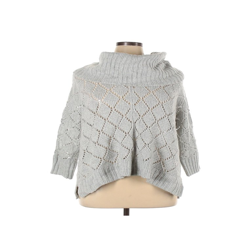

UNTUNED CAPTION: a cozy knit sweater with a flattering scoop neck and a flattering cowl neck make this a perfect layering piece for a cool day at the beach or in the city

TUNED CAPTION: a cozy knit sweater with a flattering scoop neck and a flattering cowl neck make this a perfect layering piece for a cool day at the beach or in the city

DESIRED CAPTION: This is a light grey, cable knit poncho-style sweater with ribbed turtleneck, wide arm openings, and a relaxed, draped fit, likely made from wool or acrylic blend, representing a casual and cozy style possibly from the



DF Index:6, Segment index: 1


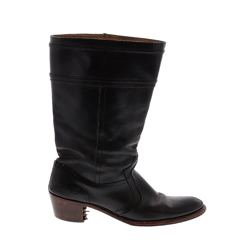

UNTUNED CAPTION: a classic boot with a pointed toe and a high heel are crafted from supple leather with a soft lining and a cushioned footbed for comfort

TUNED CAPTION: a classic boot with a pointed toe and a high heel are crafted from supple leather with a soft lining and a cushioned footbed for comfort

DESIRED CAPTION: This is a classic black leather knee-high boot featuring a slouchy shaft, a stacked heel, rounded toe, and a simple, timeless style that could be versatile for both casual and more dressed-up looks.



DF Index:137, Segment index: 2


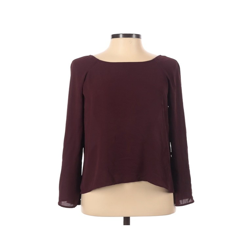

UNTUNED CAPTION: a flattering scoop neck and a flattering fit make this top a must have for your wardrobe

TUNED CAPTION: a flattering scoop neck and a flattering fit make this top a must have for your wardrobe

DESIRED CAPTION: This is a contemporary, burgundy-colored women's blouse with long sleeves, made from a light, possibly synthetic fabric, featuring a relaxed fit, a round neckline, and a high-low hemline that adds a modern touch to



DF Index:10, Segment index: 3


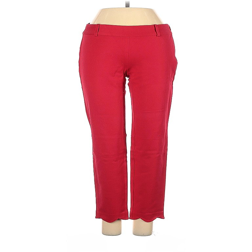

UNTUNED CAPTION: a flattering scalloped hem and a flattering fit make this relaxed pant a go-to for a casual day or weekend look

TUNED CAPTION: a flattering scalloped hem and a flattering fit make this relaxed pant a go-to for a casual day or weekend look

DESIRED CAPTION: These are red, straight-cut, mid-rise trousers likely made from a smooth, non-stretch fabric, featuring a clean waistband without belt loops, and finished with a simple hem, giving off a sleek, modern look suitable for



DF Index:128, Segment index: 4


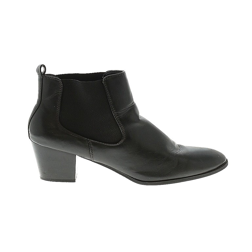

UNTUNED CAPTION: a classic chelsea boot with a pointed toe and a pointed heel are made from a soft leather with a soft hand and a smooth finish

TUNED CAPTION: a classic chelsea boot with a pointed toe and a pointed heel are made from a soft leather with a soft hand and a smooth finish

DESIRED CAPTION: This is a classic black leather Chelsea boot featuring a sleek design with elastic side panels, a modest block heel, a pointed toe, and a pull tab at the back for ease of slipping on, suitable for both casual and semi-formal styles



DF Index:23, Segment index: 5


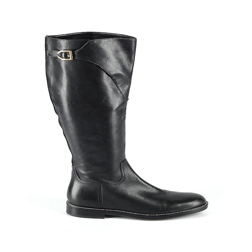

UNTUNED CAPTION: a classic buckle add a touch of class to a boot crafted from supple leather with a high heel and a low toe cut for a comfortable fit

TUNED CAPTION: a classic buckle add a touch of class to a boot crafted from supple leather with a high heel and a low toe cut for a comfortable fit

DESIRED CAPTION: This is a classic black leather knee-high boot featuring a sleek, rounded-toe design with minimal detailing except for a strap with a buckle at the top, suitable for a streamlined look that could complement both casual and slightly more formal attire.



DF Index:147, Segment index: 6


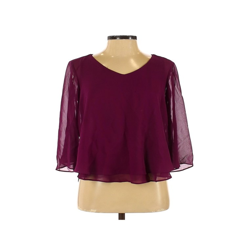

UNTUNED CAPTION: a flattering v neckline and a flattering asymmetrical hemline make this sleeveless blouse a must have for your wardrobe

TUNED CAPTION: a flattering v neckline and a flattering asymmetrical hemline make this sleeveless blouse a must have for your wardrobe

DESIRED CAPTION: This is a women's deep burgundy blouse with sheer long sleeves, featuring a v-neckline and a loose, flowy fit, likely made from a synthetic blend, presenting a simple yet elegant style suitable for various occasions.



DF Index:74, Segment index: 7


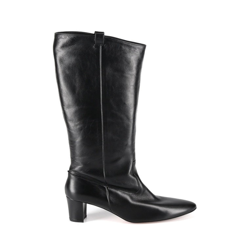

UNTUNED CAPTION: a pointed toe and a pointed heel make this boot a must have for any season

TUNED CAPTION: a pointed toe and a pointed heel make this boot a must have for any season

DESIRED CAPTION: This is a pair of classic black leather knee-high boots featuring a sleek, fitted silhouette with a pointed toe, mid-height block heel, with a full-length zipper on the shaft, likely from a contemporary era and versatile for various styles





In [95]:
compareCaptionsAfter(comparison_segment_g,
                         comparison_hf_indices_g,
                         comparison_pixel_value_inputs_g,
                         comparison_predictions_untuned_g,
                         comparison_labels_g)

## KARINA TO DO:

* commit that refactored for clarity and addressed bug when displaying before and after demo data
* make a similar items benchmark csv of deduped data so can use this data as a test once have model trained
* don't need a multi-GPU instance unless change code to be able to take advantage
* implement Regi's nbdev approach to organize jupyter notebooks then delete Regis scratchpad from this notebook


## REGIS SCRATCHPAD

Command line to get list of deduplicated files in a folder: ffor file in *; do md5sum "$file"; done | sort | awk '!seen[$1]++ {print $2}

https://nbdev.fast.ai # from jeremy howard see youtube

### dataloader

### code

In [96]:
# # nbdev: EXPORT
# def load_dataset(path):
#     # return a dataset
#     pass
#     return x

### tests

In [97]:
# # create a folder
# #create 3 images inside
# ds = load_dataset('./test123')
# assert len(ds) == 3
# assert ds[0]['filename'] == 'first.jpg'
# assert ds.isin(..) != ...